In [ ]:
import os
import zipfile

def unzip_data(zip_path, extract_to="./data"):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"✅ Dataset extracted to: {extract_to}")

# Example usage:
unzip_data("/content/archive.zip", "./data")

✅ Dataset extracted to: ./data


In [ ]:
# Colab usually has these, but safe to include
!pip install torch torchvision opencv-python matplotlib pillow


In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])


In [ ]:
def get_loaders(data_dir, batch_size=16, val_ratio=0.2):
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)

    val_size = int(len(dataset) * val_ratio)
    train_size = len(dataset) - val_size

    train_data, val_data = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    print("Class order:", dataset.classes)
    return train_loader, val_loader, len(dataset.classes), dataset.classes, dataset

In [ ]:
total_data_size=len(full_dataset)
train_split_size = len(train_loader.dataset)
val_split_size = len(val_loader.dataset)
print(f"Total data samples: {total_data_size}")
print(f"Training data samples: {train_split_size}")
print(f"Validation data samples: {val_split_size}")

Total data samples: 253
Training data samples: 203
Validation data samples: 50


In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))


def build_cnn(num_classes):
    return CustomCNN(num_classes)


In [ ]:
import psutil
import time

def evaluate(model, loader, device):
    model.eval()
    correct = total = 0
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(1)
            loss = criterion(outputs, y)
            running_loss += loss.item() * y.size(0)
            correct += (preds == y).sum().item()
            total += y.size(0)

    accuracy = 100 * correct / total
    avg_loss = running_loss / total
    return accuracy, avg_loss


def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), lr=lr
    )

    process = psutil.Process()

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    epoch_times = []
    ram_usages = []


    for epoch in range(epochs):
        start_time = time.time()  # Start time for the epoch

        model.train()

        running_loss = 0.0
        correct = 0
        total = 0

        # -------- TRAINING LOOP --------
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = 100.0 * correct / total

        # -------- VALIDATION --------
        val_acc, val_loss = evaluate(model, val_loader, device)

        end_time = time.time()  # End time for the epoch
        epoch_time = end_time - start_time

        # Get RAM usage (in MB)
        ram_usage_mb = process.memory_info().rss / (1024 * 1024)

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Time: {epoch_time:.2f}s | "
            f"RAM: {ram_usage_mb:.2f} MB | "
            f"Train Loss: {train_loss:.4f} | "
            f"Train Acc: {train_acc:.2f}% | "
            f"Val Loss: {val_loss:.4f} | "
            f"Val Acc: {val_acc:.2f}%"
        )

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        epoch_times.append(epoch_time)
        ram_usages.append(ram_usage_mb)


    return model, train_losses, train_accuracies, val_losses, val_accuracies, epoch_times, ram_usages


In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self._forward_hook)
        target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, x, class_idx):
        self.model.zero_grad()

        output = self.model(x)
        score = output[0, class_idx]

        score.backward(retain_graph=True)

        if self.gradients is None:
            raise RuntimeError(
                "Gradients are None. Make sure target layer requires_grad=True."
            )

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = torch.relu(cam)
        cam = (cam - cam.min()) / (cam.max() + 1e-8)

        return cam[0].detach().cpu().numpy()

In [ ]:
def get_target_layer(model):
    if isinstance(model, CustomCNN):
        return model.features[-2]       # Conv2d(64 → 128)

    raise ValueError("Unsupported model")

In [ ]:
def predict_with_gradcam_pp(model, img_path, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval().to(device)

    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    # ---- Load image ----
    img_pil = Image.open(img_path).convert("RGB")
    img_tensor = transform(img_pil).unsqueeze(0).to(device)

    # ---- Prediction ----
    output = model(img_tensor)
    pred_class = output.argmax(dim=1).item()
    print("Prediction:", class_names[pred_class])

    # ---- Grad-CAM / Grad-CAM++ ----
    cam_generator = GradCAM(model, get_target_layer(model))
    cam = cam_generator.generate(img_tensor, pred_class)  # e.g. 28×28

    # ---- Resize CAM ----
    cam = cv2.resize(cam, (224,224))

    # ✅ ---- Smooth CAM (CORRECT PLACE) ----
    cam = cv2.GaussianBlur(cam, (7,7), 0)

    # ---- Original image for overlay ----
    img_cv = cv2.resize(cv2.imread(img_path), (224,224))

    # ---- Heatmap + overlay ----
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_cv, 0.6, heatmap, 0.4, 0)

    # ---- Display ----
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.title("Original MRI")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(cam, cmap="jet")
    plt.title("Grad-CAM (smoothed)")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {class_names[pred_class]}")
    plt.axis("off")

    plt.show()

In [ ]:
data_dir = "/content/data/brain_tumor_dataset"

train_loader, val_loader, num_classes, class_names, full_dataset = get_loaders(data_dir)

model1 =build_cnn(num_classes)
model1, train_losses_model1, train_acc1, val_losses_model1, val_acc1 ,epoch_times1, ram_usages1= \
    train_model(model1, train_loader, val_loader, epochs=10)


Class order: ['no', 'yes']
Epoch [1/10] | Time: 29.09s | RAM: 5528.16 MB | Train Loss: 0.6833 | Train Acc: 59.11% | Val Loss: 0.6319 | Val Acc: 54.00%
Epoch [2/10] | Time: 26.36s | RAM: 5747.71 MB | Train Loss: 0.5474 | Train Acc: 74.88% | Val Loss: 0.4890 | Val Acc: 82.00%
Epoch [3/10] | Time: 27.83s | RAM: 5638.41 MB | Train Loss: 0.4785 | Train Acc: 76.85% | Val Loss: 0.4759 | Val Acc: 82.00%
Epoch [4/10] | Time: 27.27s | RAM: 5691.12 MB | Train Loss: 0.4114 | Train Acc: 79.80% | Val Loss: 0.5332 | Val Acc: 80.00%
Epoch [5/10] | Time: 27.44s | RAM: 5659.85 MB | Train Loss: 0.3782 | Train Acc: 81.28% | Val Loss: 0.3900 | Val Acc: 82.00%
Epoch [6/10] | Time: 28.77s | RAM: 5638.41 MB | Train Loss: 0.3440 | Train Acc: 85.22% | Val Loss: 0.3987 | Val Acc: 84.00%
Epoch [7/10] | Time: 28.02s | RAM: 5690.48 MB | Train Loss: 0.2822 | Train Acc: 90.15% | Val Loss: 0.6622 | Val Acc: 80.00%
Epoch [8/10] | Time: 26.29s | RAM: 5722.63 MB | Train Loss: 0.2642 | Train Acc: 90.15% | Val Loss: 0.5375

Prediction: no


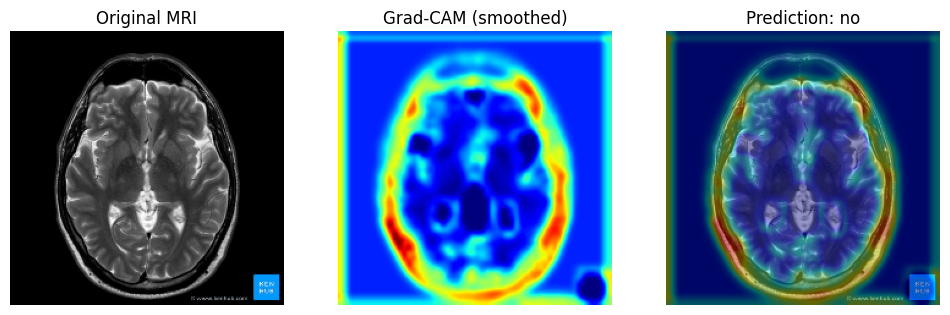

Prediction: no


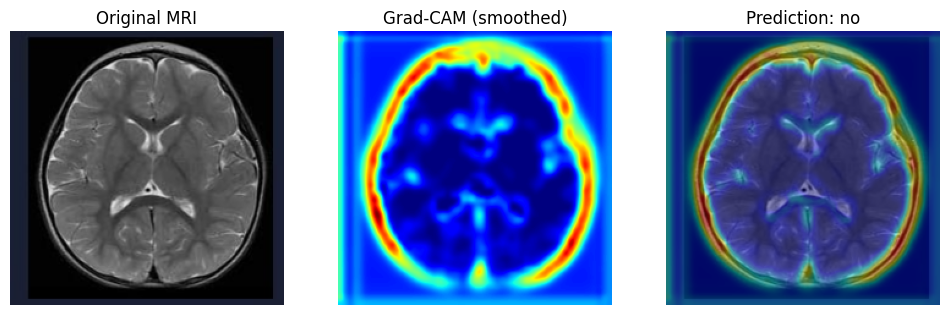

Prediction: yes


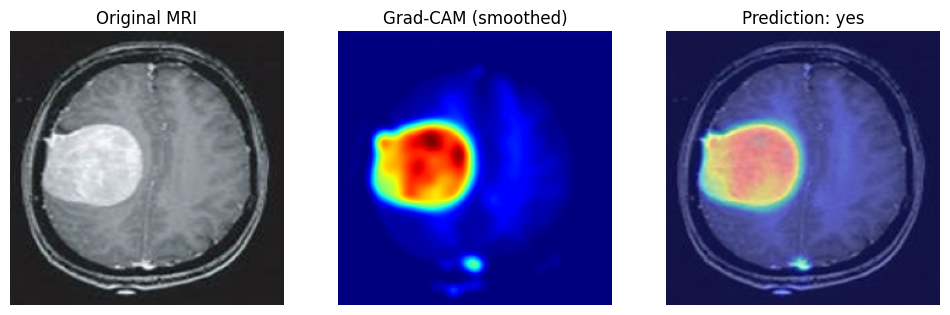

Prediction: yes


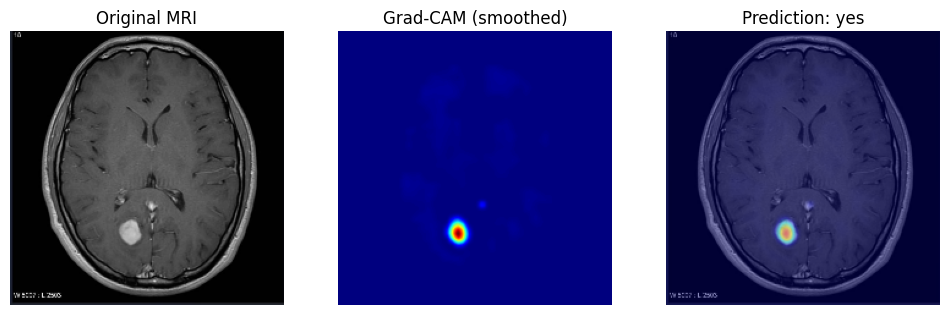

Prediction: no


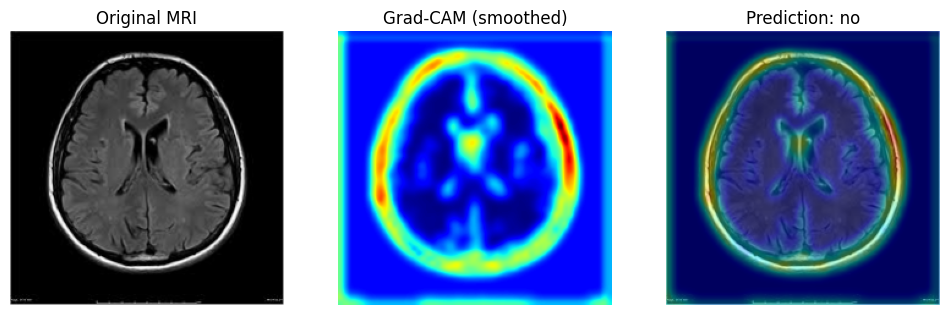

In [ ]:
predict_with_gradcam_pp(model1, "/content/6255540375829285640.jpg",class_names)
predict_with_gradcam_pp(model1, "/content/6255540375829285639.jpg",class_names)
predict_with_gradcam_pp(model1, "/content/6255540375829285644.jpg",class_names)
predict_with_gradcam_pp(model1, "/content/6255540375829285651.jpg",class_names)
predict_with_gradcam_pp(model1, "/content/5 no.jpg",class_names)

In [ ]:
overall_loader = DataLoader(full_dataset, batch_size=16, shuffle=False)
overall_accuracy, overall_loss = evaluate(model1, overall_loader, device)
print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(f"Overall Loss: {overall_loss:.4f}")

Overall Accuracy: 94.86%
Overall Loss: 0.1931


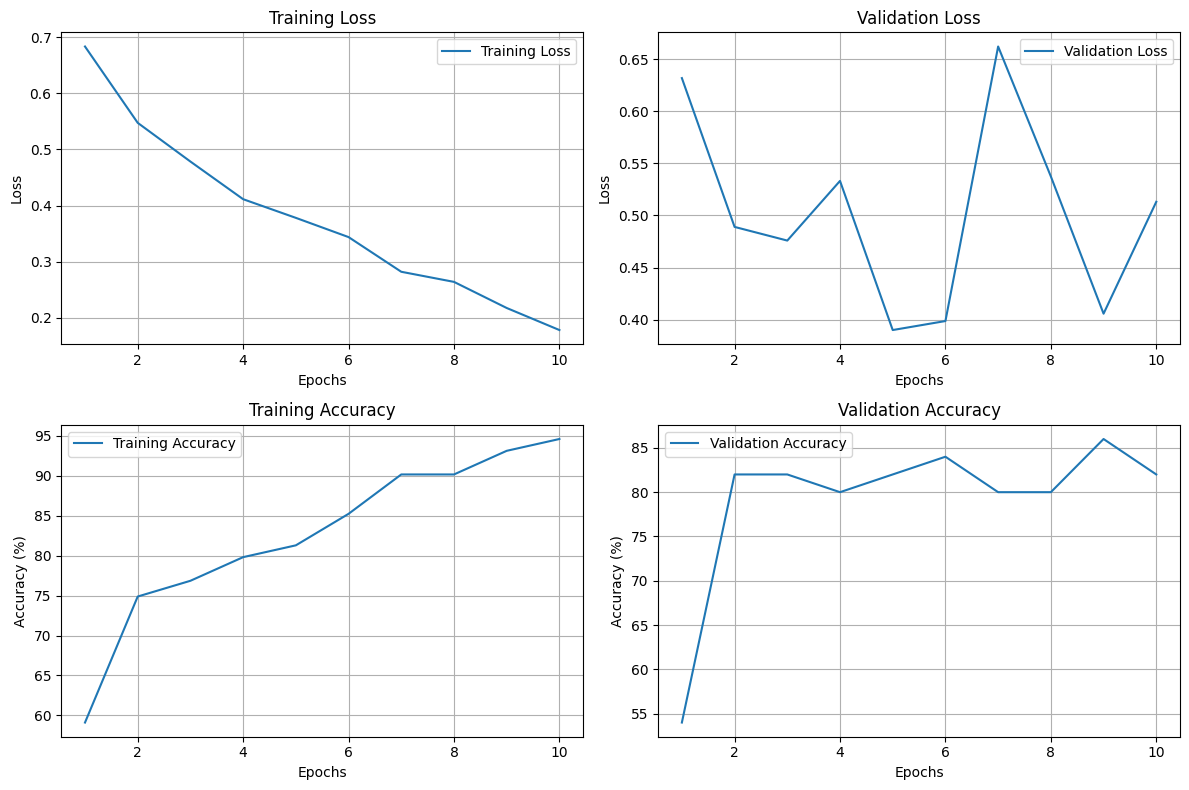

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses_model1) + 1)

plt.figure(figsize=(12, 8))

# ------------------ Training Loss ------------------
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses_model1, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# ------------------ Validation Loss ------------------
plt.subplot(2, 2, 2)
plt.plot(epochs, val_losses_model1, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# ------------------ Training Accuracy ------------------
plt.subplot(2, 2, 3)
plt.plot(epochs, train_acc1, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# ------------------ Validation Accuracy ------------------
plt.subplot(2, 2, 4)
plt.plot(epochs, val_acc1, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_epoch_time_ram_table(epoch_times1, ram_usages1):
    epochs = list(range(1, len(epoch_times1) + 1))

    # Create table data
    table_data = [
        [epochs[i], f"{epoch_times1[i]:.2f}", f"{ram_usages1[i]:.2f}"]
        for i in range(len(epochs))
    ]

    column_labels = ["Epoch", "Time (seconds)", "RAM Usage (MB)"]

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 0.6 * len(epochs)))
    ax.axis("off")

    table = ax.table(
        cellText=table_data,
        colLabels=column_labels,
        cellLoc="center",
        loc="center"
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    plt.title("Epoch-wise Time and RAM Usage", pad=20)
    plt.show()


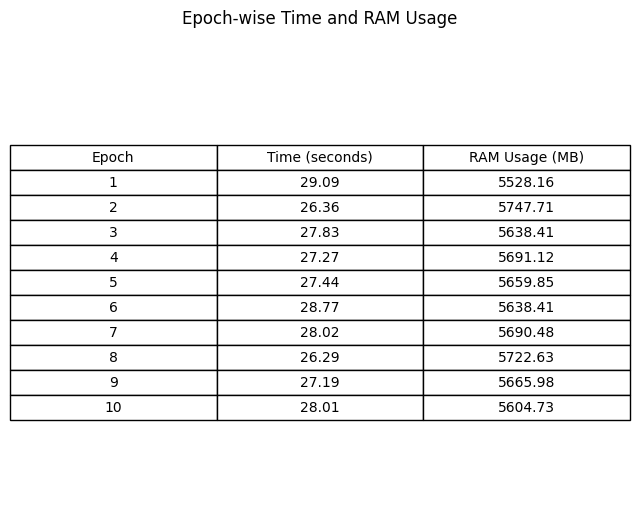

In [ ]:
plot_epoch_time_ram_table(epoch_times1, ram_usages1)

In [ ]:
data_dir = "/content/data/brain_tumor_dataset"

train_loader, val_loader, num_classes, class_names, full_dataset = get_loaders(data_dir)

model2 =build_cnn(num_classes)

model2, train_losses_model2, train_acc2, val_losses_model2, val_acc2, epoch_times2, \
ram_usages2 = \
    train_model(model2, train_loader, val_loader, epochs=15)

Class order: ['no', 'yes']
Epoch [1/15] | Time: 28.08s | RAM: 5859.64 MB | Train Loss: 0.6866 | Train Acc: 58.62% | Val Loss: 0.7528 | Val Acc: 52.00%
Epoch [2/15] | Time: 30.05s | RAM: 5832.96 MB | Train Loss: 0.5368 | Train Acc: 71.92% | Val Loss: 0.5924 | Val Acc: 72.00%
Epoch [3/15] | Time: 26.48s | RAM: 5774.01 MB | Train Loss: 0.4484 | Train Acc: 82.76% | Val Loss: 0.6004 | Val Acc: 78.00%
Epoch [4/15] | Time: 28.19s | RAM: 5829.90 MB | Train Loss: 0.3895 | Train Acc: 83.74% | Val Loss: 0.6071 | Val Acc: 74.00%
Epoch [5/15] | Time: 28.73s | RAM: 5805.28 MB | Train Loss: 0.3550 | Train Acc: 86.70% | Val Loss: 0.5765 | Val Acc: 74.00%
Epoch [6/15] | Time: 27.44s | RAM: 5871.12 MB | Train Loss: 0.3184 | Train Acc: 86.70% | Val Loss: 0.5344 | Val Acc: 74.00%
Epoch [7/15] | Time: 27.89s | RAM: 5780.78 MB | Train Loss: 0.2562 | Train Acc: 92.12% | Val Loss: 0.5552 | Val Acc: 74.00%
Epoch [8/15] | Time: 26.65s | RAM: 5943.21 MB | Train Loss: 0.2048 | Train Acc: 93.60% | Val Loss: 0.5506

Prediction: no


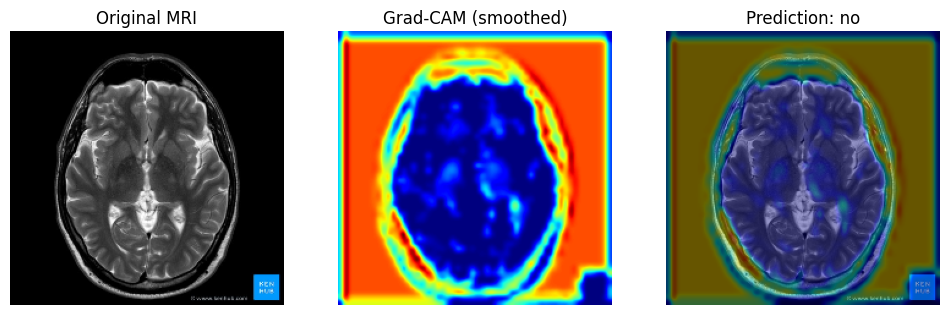

Prediction: no


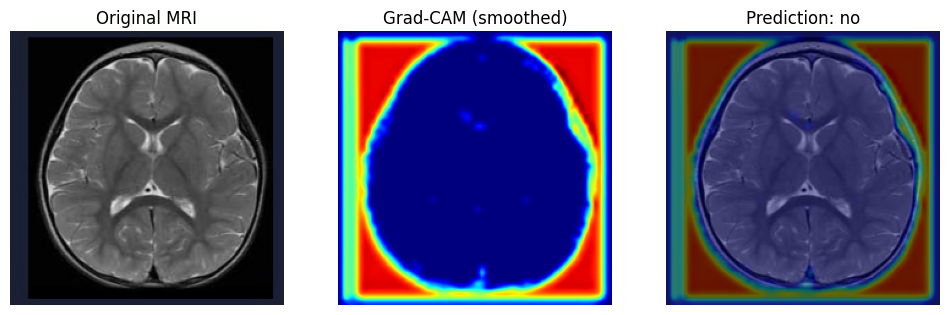

Prediction: yes


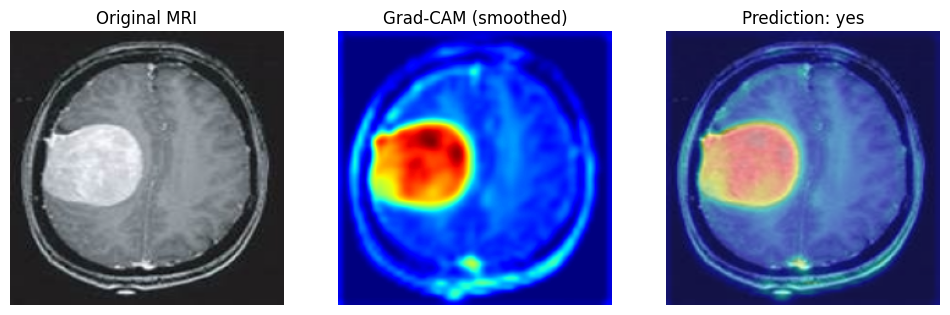

Prediction: yes


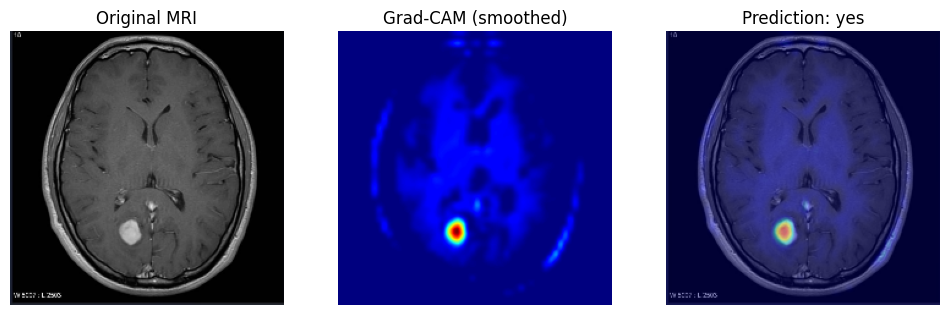

Prediction: no


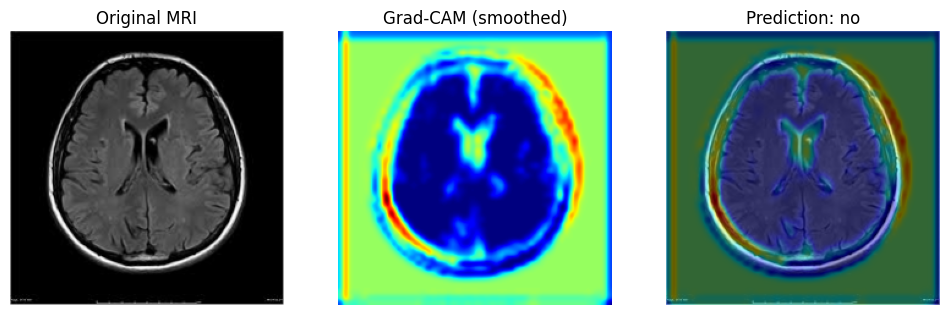

In [ ]:
predict_with_gradcam_pp(model2, "/content/6255540375829285640.jpg",class_names)
predict_with_gradcam_pp(model2, "/content/6255540375829285639.jpg",class_names)
predict_with_gradcam_pp(model2, "/content/6255540375829285644.jpg",class_names)
predict_with_gradcam_pp(model2, "/content/6255540375829285651.jpg",class_names)
predict_with_gradcam_pp(model2, "/content/5 no.jpg",class_names)

In [ ]:
overall_loader = DataLoader(full_dataset, batch_size=16, shuffle=False)
overall_accuracy, overall_loss = evaluate(model2, overall_loader, device)
print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(f"Overall Loss: {overall_loss:.4f}")

Overall Accuracy: 96.05%
Overall Loss: 0.1542


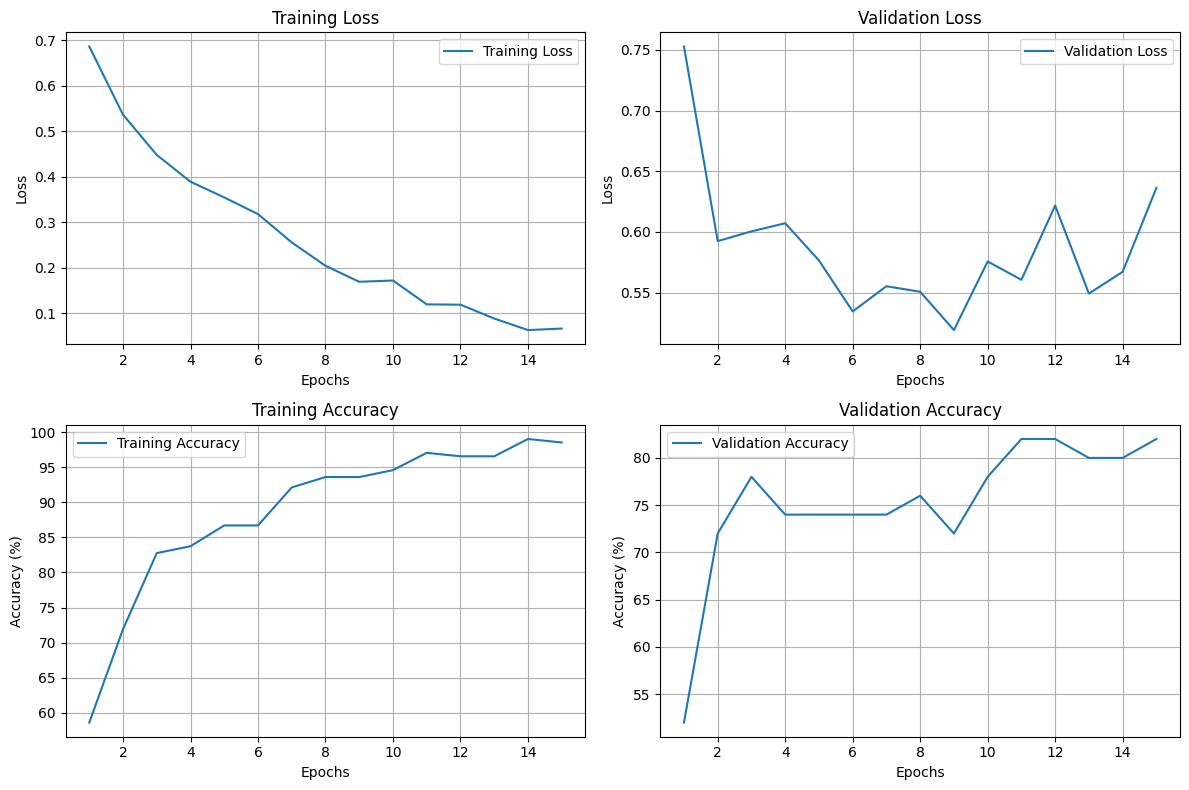

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_losses_model2) + 1))


plt.figure(figsize=(12, 8))

# ------------------ Training Loss ------------------
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses_model2, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# ------------------ Validation Loss ------------------
plt.subplot(2, 2, 2)
plt.plot(epochs, val_losses_model2, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# ------------------ Training Accuracy ------------------
plt.subplot(2, 2, 3)
plt.plot(epochs, train_acc2, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# ------------------ Validation Accuracy ------------------
plt.subplot(2, 2, 4)
plt.plot(epochs, val_acc2, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


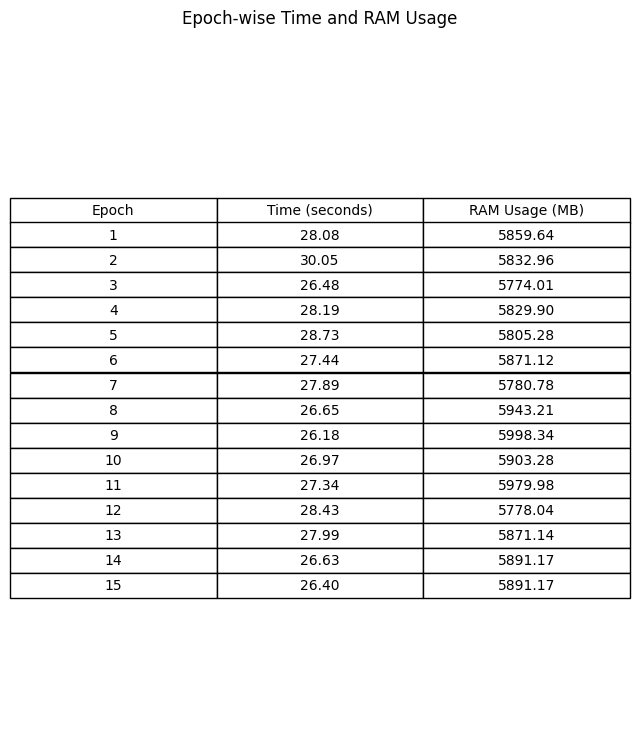

In [ ]:
import matplotlib.pyplot as plt

def plot_epoch_time_ram_table(epoch_times2, ram_usages2):
    epochs = list(range(1, len(epoch_times2) + 1))

    # Create table data
    table_data = [
        [epochs[i], f"{epoch_times2[i]:.2f}", f"{ram_usages2[i]:.2f}"]
        for i in range(len(epochs))
    ]

    column_labels = ["Epoch", "Time (seconds)", "RAM Usage (MB)"]

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 0.6 * len(epochs)))
    ax.axis("off")

    table = ax.table(
        cellText=table_data,
        colLabels=column_labels,
        cellLoc="center",
        loc="center"
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    plt.title("Epoch-wise Time and RAM Usage", pad=20)
    plt.show()

plot_epoch_time_ram_table(epoch_times2, ram_usages2)

In [ ]:
data_dir = "/content/data/brain_tumor_dataset"

train_loader, val_loader, num_classes, class_names, full_dataset = get_loaders(data_dir)

model3 =build_cnn(num_classes)

model3, train_losses_model3, train_acc3, val_losses_model3, val_acc3, epoch_times3, \
ram_usages3 = \
    train_model(model3, train_loader, val_loader, epochs=25)

Class order: ['no', 'yes']
Epoch [1/25] | Time: 31.02s | RAM: 4644.62 MB | Train Loss: 0.6639 | Train Acc: 60.10% | Val Loss: 0.6199 | Val Acc: 82.00%
Epoch [2/25] | Time: 31.90s | RAM: 4645.39 MB | Train Loss: 0.4959 | Train Acc: 79.31% | Val Loss: 0.5796 | Val Acc: 82.00%
Epoch [3/25] | Time: 34.05s | RAM: 4653.81 MB | Train Loss: 0.4416 | Train Acc: 79.80% | Val Loss: 0.5670 | Val Acc: 68.00%
Epoch [4/25] | Time: 29.83s | RAM: 4644.62 MB | Train Loss: 0.4315 | Train Acc: 80.30% | Val Loss: 0.5191 | Val Acc: 74.00%
Epoch [5/25] | Time: 28.54s | RAM: 4653.94 MB | Train Loss: 0.3825 | Train Acc: 84.73% | Val Loss: 0.5576 | Val Acc: 86.00%
Epoch [6/25] | Time: 28.50s | RAM: 4620.25 MB | Train Loss: 0.3518 | Train Acc: 84.73% | Val Loss: 0.4827 | Val Acc: 78.00%
Epoch [7/25] | Time: 28.36s | RAM: 4653.94 MB | Train Loss: 0.3044 | Train Acc: 89.66% | Val Loss: 0.4901 | Val Acc: 72.00%
Epoch [8/25] | Time: 27.59s | RAM: 4636.97 MB | Train Loss: 0.2660 | Train Acc: 90.15% | Val Loss: 0.4787

Prediction: no


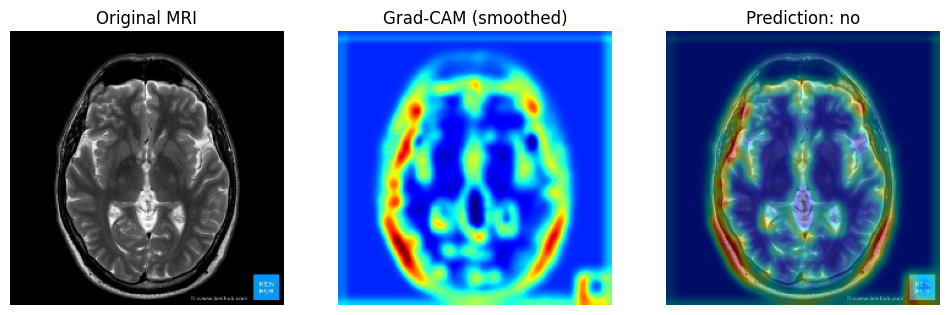

Prediction: no


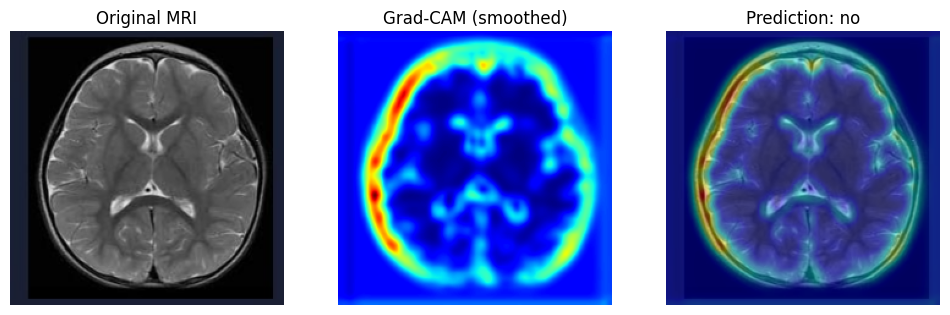

Prediction: yes


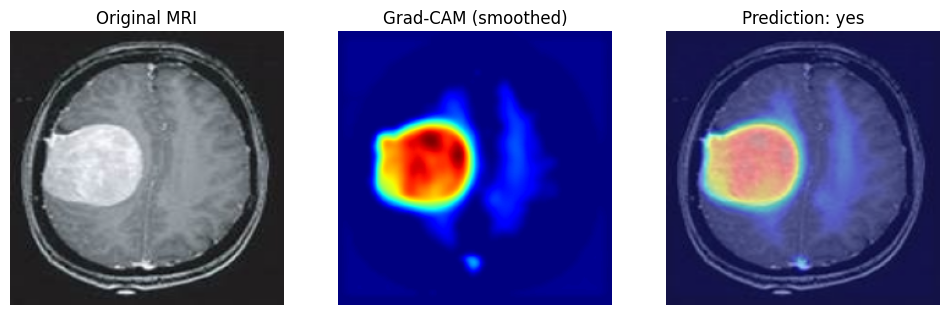

Prediction: yes


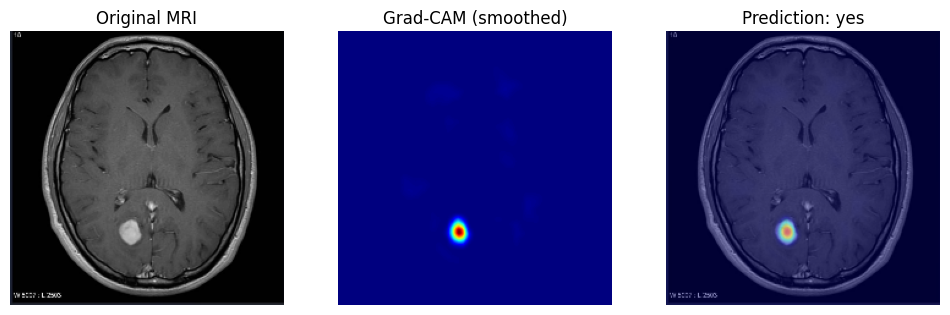

Prediction: no


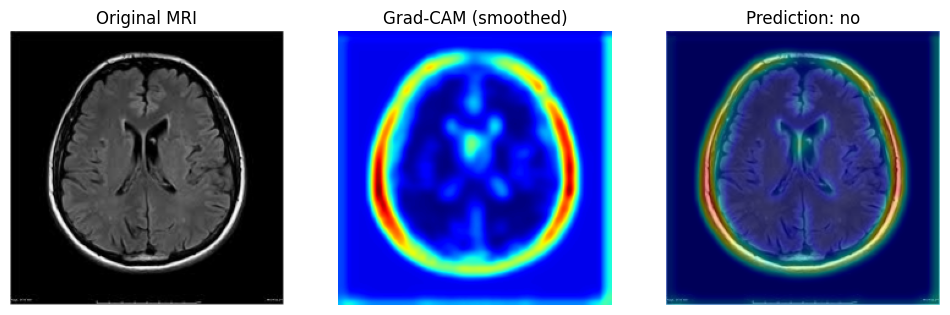

In [ ]:
predict_with_gradcam_pp(model3, "/content/6255540375829285640.jpg",class_names)
predict_with_gradcam_pp(model3, "/content/6255540375829285639.jpg",class_names)
predict_with_gradcam_pp(model3, "/content/6255540375829285644.jpg",class_names)
predict_with_gradcam_pp(model3, "/content/6255540375829285651.jpg",class_names)
predict_with_gradcam_pp(model3, "/content/5 no.jpg",class_names)

In [ ]:
overall_loader = DataLoader(full_dataset, batch_size=16, shuffle=False)
overall_accuracy, overall_loss = evaluate(model3, overall_loader, device)
print(f"Overall Accuracy: {overall_accuracy:.2f}%")
print(f"Overall Loss: {overall_loss:.4f}")

Overall Accuracy: 96.05%
Overall Loss: 0.1167


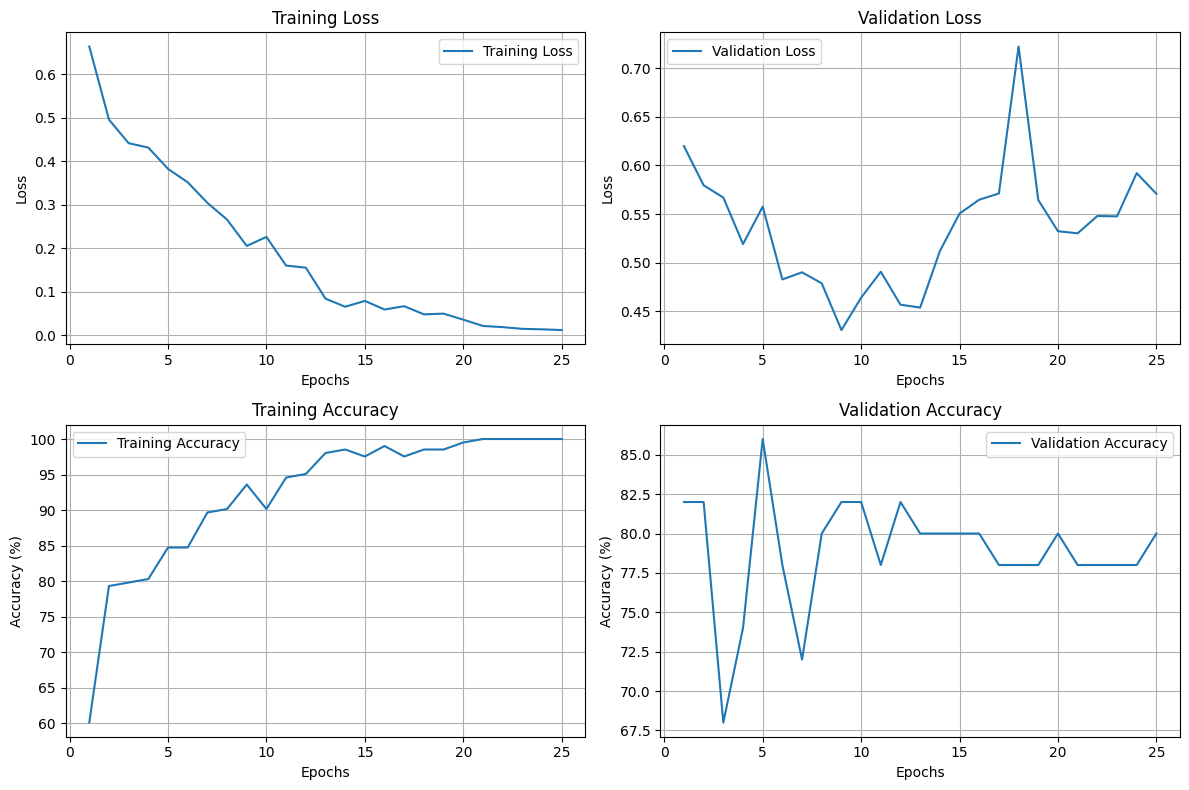

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_losses_model3) + 1))


plt.figure(figsize=(12, 8))

# ------------------ Training Loss ------------------
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses_model3, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# ------------------ Validation Loss ------------------
plt.subplot(2, 2, 2)
plt.plot(epochs, val_losses_model3, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# ------------------ Training Accuracy ------------------
plt.subplot(2, 2, 3)
plt.plot(epochs, train_acc3, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# ------------------ Validation Accuracy ------------------
plt.subplot(2, 2, 4)
plt.plot(epochs, val_acc3, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


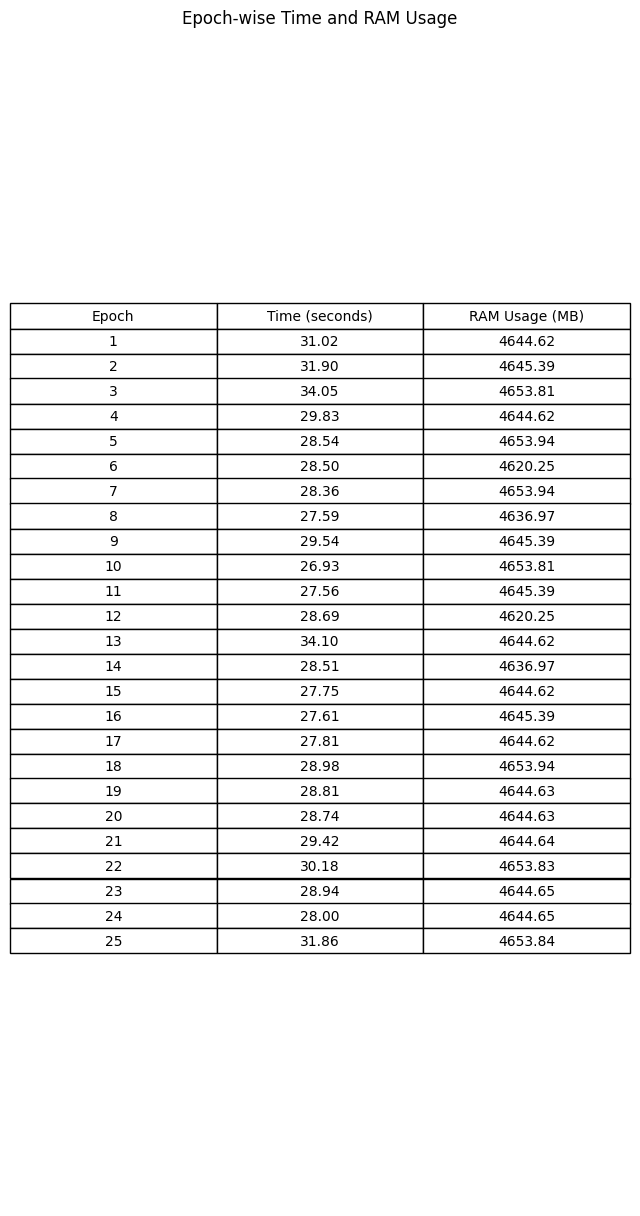

In [ ]:
import matplotlib.pyplot as plt

def plot_epoch_time_ram_table(epoch_times3, ram_usages3):
    epochs = list(range(1, len(epoch_times3) + 1))

    # Create table data
    table_data = [
        [epochs[i], f"{epoch_times3[i]:.2f}", f"{ram_usages3[i]:.2f}"]
        for i in range(len(epochs))
    ]

    column_labels = ["Epoch", "Time (seconds)", "RAM Usage (MB)"]

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 0.6 * len(epochs)))
    ax.axis("off")

    table = ax.table(
        cellText=table_data,
        colLabels=column_labels,
        cellLoc="center",
        loc="center"
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    plt.title("Epoch-wise Time and RAM Usage", pad=20)
    plt.show()

plot_epoch_time_ram_table(epoch_times3, ram_usages3)